In [1]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
import seaborn as sns
from matplotlib import pylab as plt
from statsmodels.regression.linear_model import OLS

def plot_lr(true_coefs, est_coefs, pvals, var_names=None):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(15, 7))
    if true_coefs is not None:
        plt.scatter(np.arange(X.shape[1]), true_coefs, color='black', label='true betas', alpha=0.5)
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, color='red', label='estimated betas', alpha=0.5)
    # print significant betas
    axes = plt.gca()
    y_max, _ = axes.get_ylim()
    sign_y = np.sum(where_sign) * [y_max]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    if var_names is None:
        plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1))
    else:
        plt.xticks(np.arange(n_feat), var_names)
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right')

def plot_regr_paths(coefs, accs, nonzeros, C_grid, var_names=None):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = len(coefs)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    if var_names is None:
        X_colnames = np.arange(n_feat) + 1
    else:
        X_colnames = var_names
            
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=8.5, markerscale=10)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    axarr[1].plot(np.arange(len(accs)), accs, color='#000000',
                     linewidth=3)
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0.0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].set_title('LASSO: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

/Users/admin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = iter(folder).next()

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = clf.score(X[test_inds, :], y[test_inds])

            sample_accs.append(acc)        
            sample_coef.append(clf.coef_)

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        notzero = np.count_nonzero(mean_coefs)
        print "alpha: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero)
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2)

Diabetes dataset
================

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.
(http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

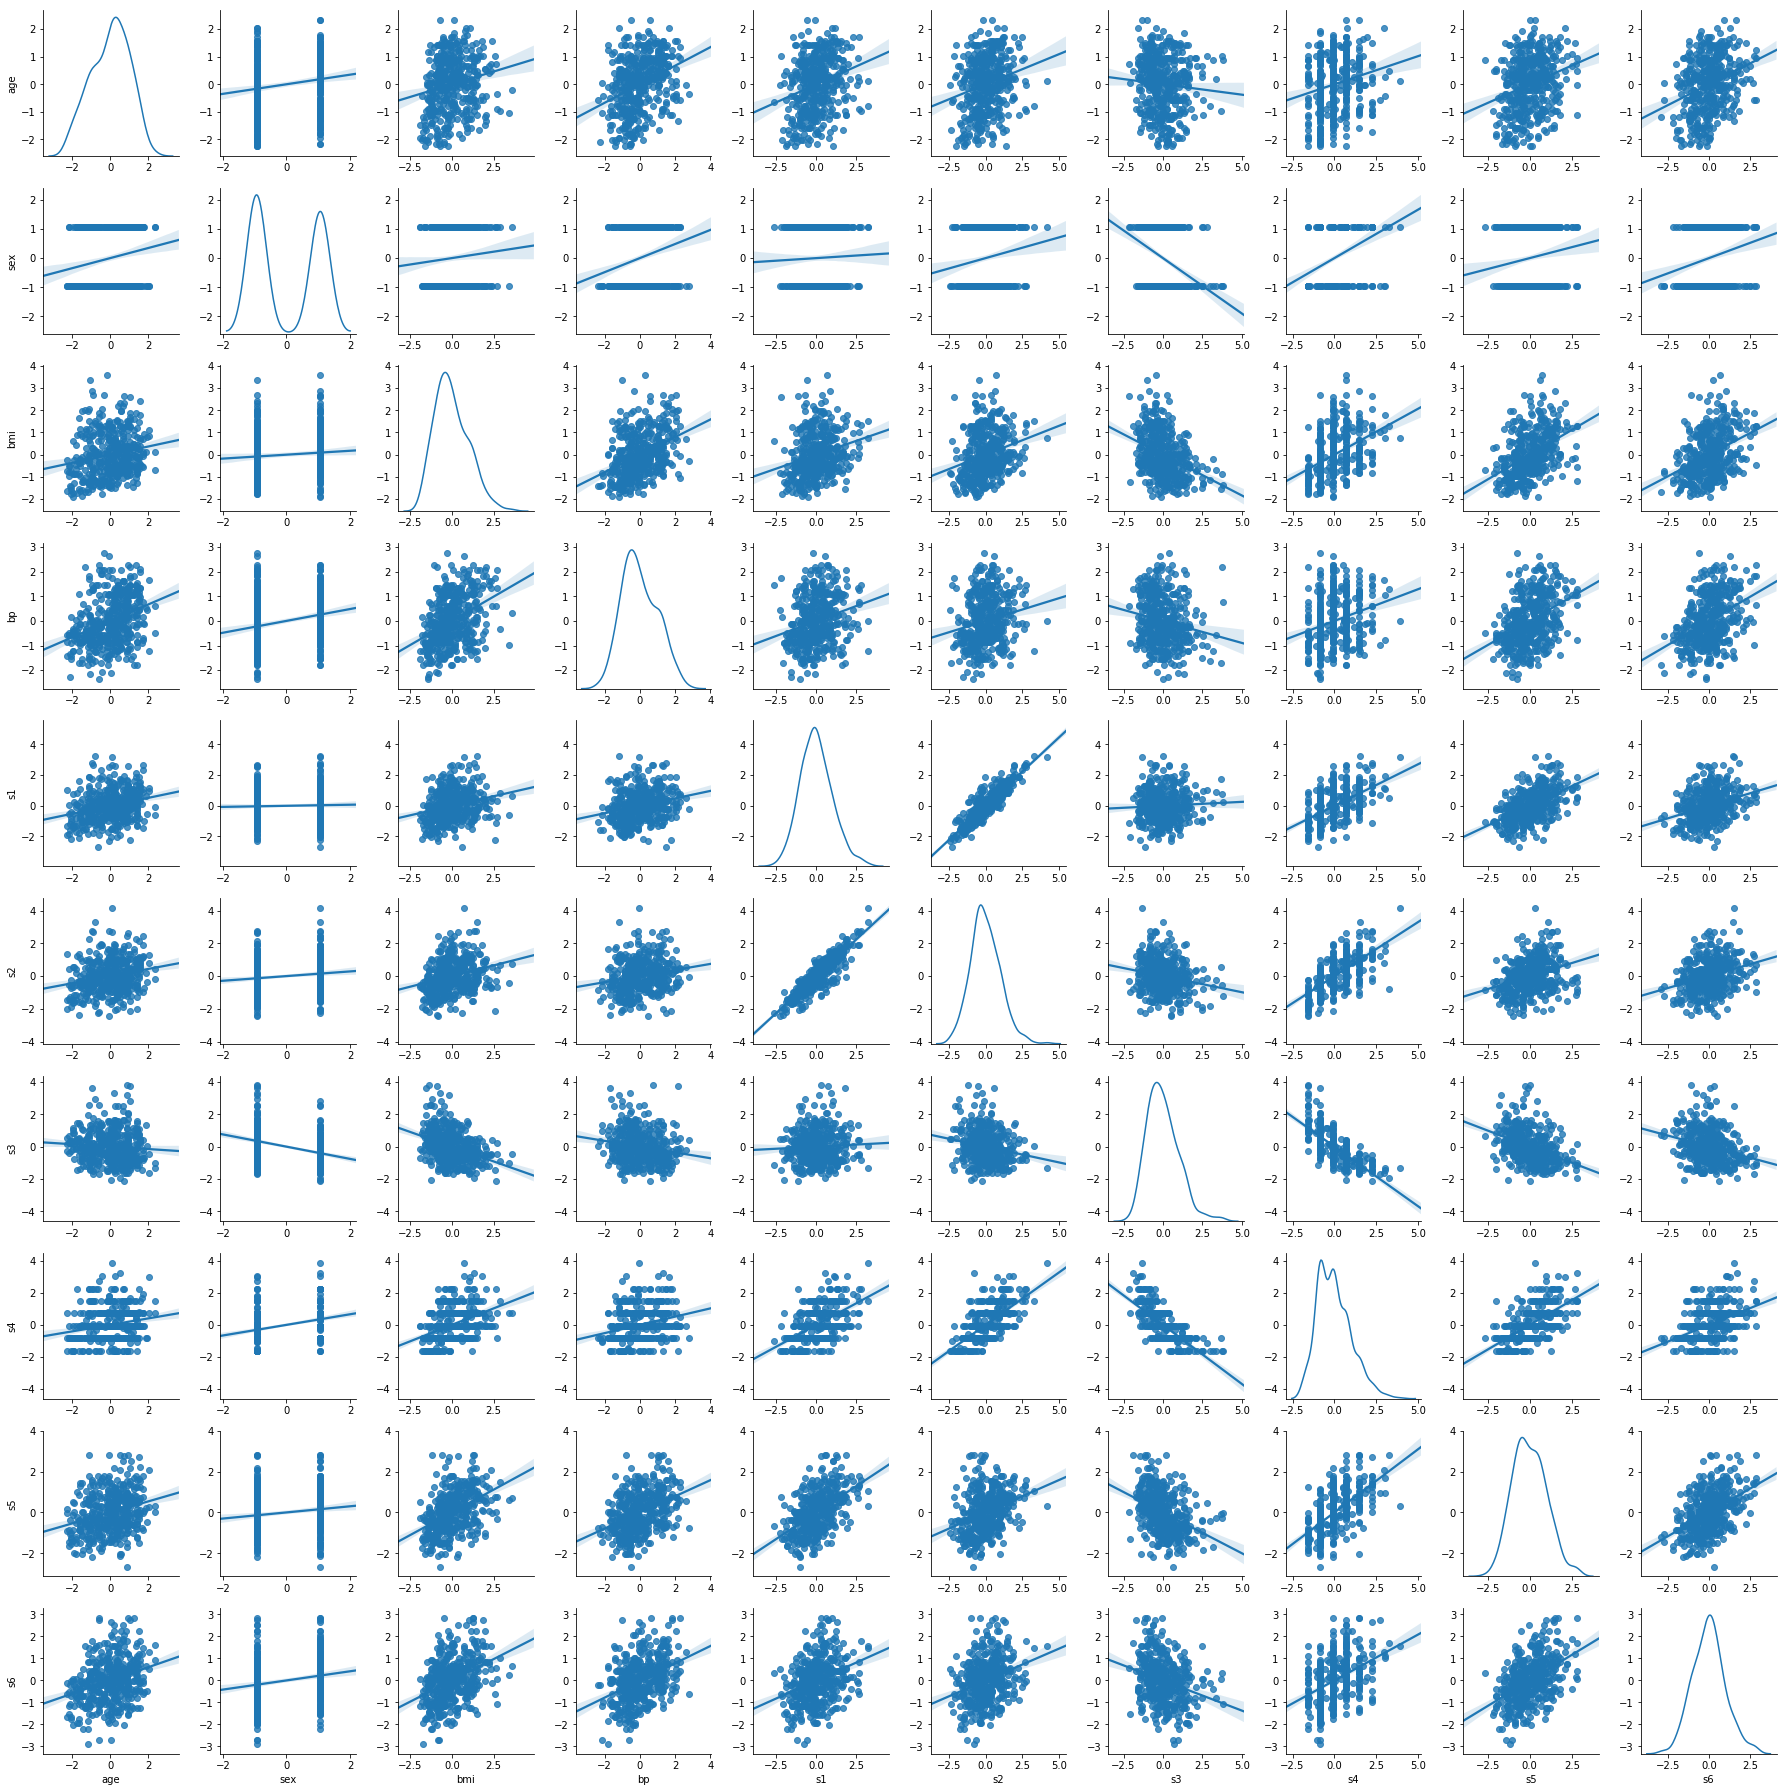

In [3]:
import sklearn.datasets as ds  
bun = ds.load_diabetes()
X, y = bun.data, bun.target
X = StandardScaler().fit_transform(X)
feat_names = bun.feature_names

sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")

#sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
#             kind="reg", diag_kind="kde",
#             hue='out')

alpha: 0.0100 acc: 0.51 active_coefs: 10
alpha: 0.0147 acc: 0.51 active_coefs: 10
alpha: 0.0215 acc: 0.51 active_coefs: 10
alpha: 0.0316 acc: 0.51 active_coefs: 10
alpha: 0.0464 acc: 0.51 active_coefs: 10
alpha: 0.0681 acc: 0.51 active_coefs: 10
alpha: 0.1000 acc: 0.51 active_coefs: 10
alpha: 0.1468 acc: 0.50 active_coefs: 10
alpha: 0.2154 acc: 0.50 active_coefs: 10
alpha: 0.3162 acc: 0.50 active_coefs: 10
alpha: 0.4642 acc: 0.50 active_coefs: 9
alpha: 0.6813 acc: 0.50 active_coefs: 9
alpha: 1.0000 acc: 0.50 active_coefs: 9
alpha: 1.4678 acc: 0.50 active_coefs: 10
alpha: 2.1544 acc: 0.49 active_coefs: 8
alpha: 3.1623 acc: 0.49 active_coefs: 8
alpha: 4.6416 acc: 0.49 active_coefs: 7
alpha: 6.8129 acc: 0.48 active_coefs: 6
alpha: 10.0000 acc: 0.46 active_coefs: 5
alpha: 14.6780 acc: 0.41 active_coefs: 4
alpha: 21.5443 acc: 0.34 active_coefs: 3
alpha: 31.6228 acc: 0.19 active_coefs: 2
alpha: 46.4159 acc: -0.01 active_coefs: 1
alpha: 68.1292 acc: -0.01 active_coefs: 0
alpha: 100.0000 acc: 

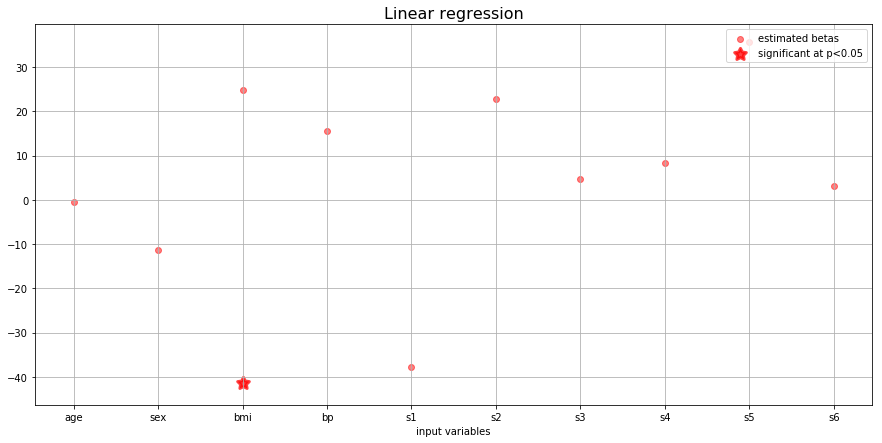

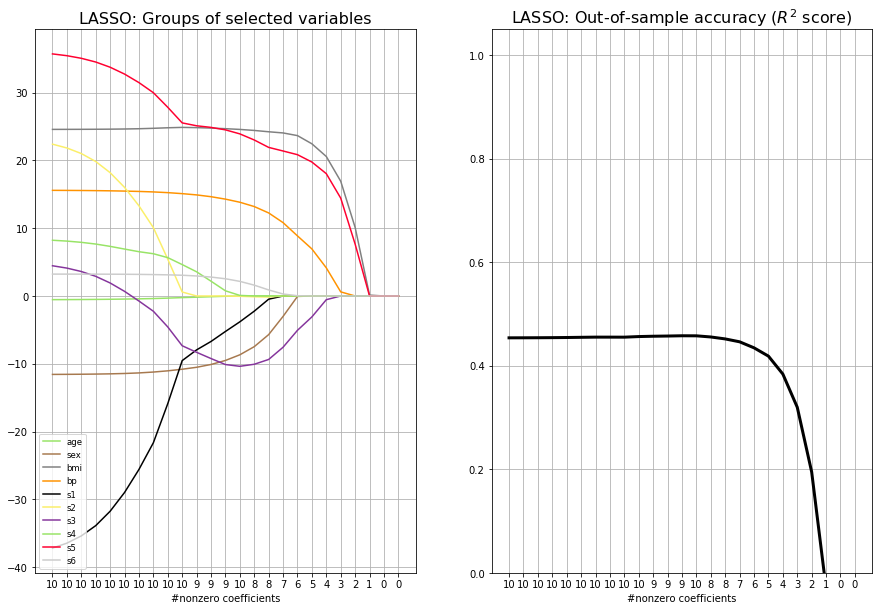

In [228]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 2, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)

### inference: only var 3 significant, prediction: this one is selected too but as predictive as var 9 and similar to 4 and 7 -> S5 is as predictive as bmi but not significant, same goes for bp and s3

In [34]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.100
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           4.72e-07
Time:                        15:20:58   Log-Likelihood:                -2873.9
No. Observations:                 442   AIC:                             5768.
Df Residuals:                     432   BIC:                             5809.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4762      8.560     -0.056      0.9

# Prostata dataset

Prostate Cancer Data
Description
These data come from a study that examined the correlation between the level of prostate specific antigen and a number of clinical measures in men who were about to receive a radical prostatectomy. It is data frame with 97 rows and 9 columns.

Usage
data(Prostate)
Format
The data frame has the following components:

lcavol
log(cancer volume)
lweight
log(prostate weight)
age
age
lbph
log(benign prostatic hyperplasia amount)
svi
seminal vesicle invasion
lcp
log(capsular penetration)
gleason
Gleason score
pgg45
percentage Gleason scores 4 or 5
lpsa
log(prostate specific antigen)
Source
Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989)
Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, Journal of Urology 141(5), 1076–1083.

Lasso paths from Hastie et al. 2001

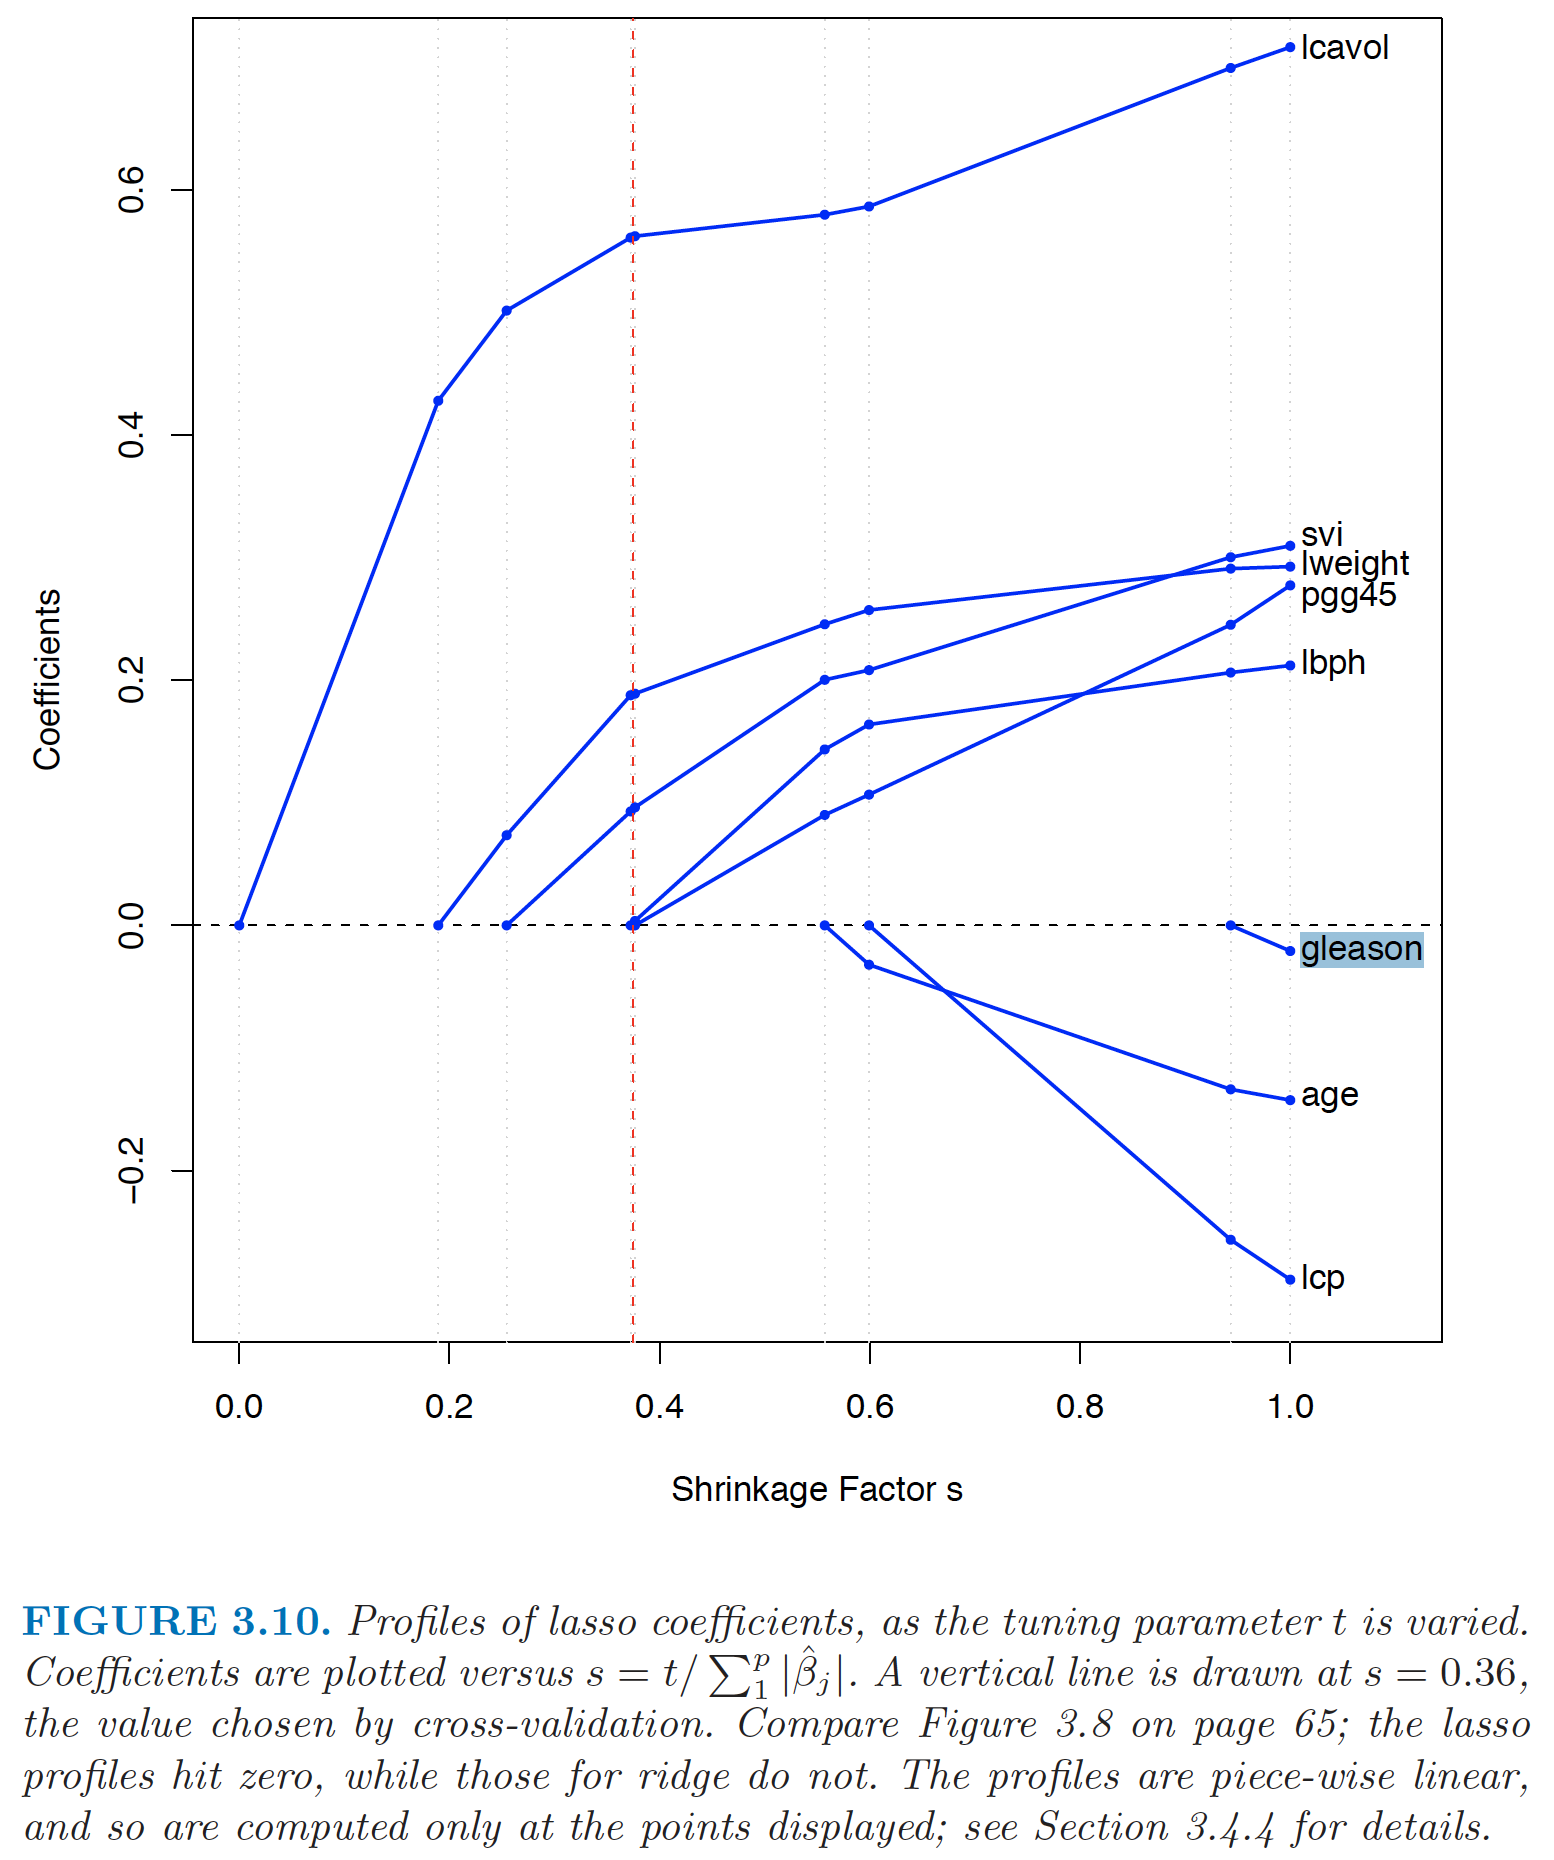

In [ ]:
import pandas as pd
df_prostate = pd.read_csv('dataset_prostate.csv')
y = df_prostate['lpsa']
feat_names = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
X = StandardScaler().fit_transform(df_prostate[feat_names])


#sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
#             kind="reg", diag_kind="kde", hue='out')

/Users/admin/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/admin/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


alpha: 0.0001 acc: -0.69 active_coefs: 8
alpha: 0.0002 acc: -0.69 active_coefs: 8
alpha: 0.0002 acc: -0.69 active_coefs: 8
alpha: 0.0003 acc: -0.69 active_coefs: 8
alpha: 0.0005 acc: -0.69 active_coefs: 8
alpha: 0.0008 acc: -0.68 active_coefs: 8
alpha: 0.0012 acc: -0.68 active_coefs: 8
alpha: 0.0017 acc: -0.68 active_coefs: 8
alpha: 0.0026 acc: -0.67 active_coefs: 8
alpha: 0.0039 acc: -0.66 active_coefs: 8
alpha: 0.0059 acc: -0.65 active_coefs: 8
alpha: 0.0089 acc: -0.63 active_coefs: 8
alpha: 0.0133 acc: -0.60 active_coefs: 8
alpha: 0.0200 acc: -0.56 active_coefs: 8
alpha: 0.0301 acc: -0.49 active_coefs: 8
alpha: 0.0453 acc: -0.40 active_coefs: 7
alpha: 0.0681 acc: -0.28 active_coefs: 8
alpha: 0.1024 acc: -0.13 active_coefs: 7
alpha: 0.1540 acc: 0.02 active_coefs: 5
alpha: 0.2315 acc: 0.13 active_coefs: 5
alpha: 0.3481 acc: 0.14 active_coefs: 3
alpha: 0.5233 acc: 0.03 active_coefs: 2
alpha: 0.7867 acc: -0.41 active_coefs: 1
alpha: 1.1828 acc: -0.64 active_coefs: 0
alpha: 1.7783 acc: -

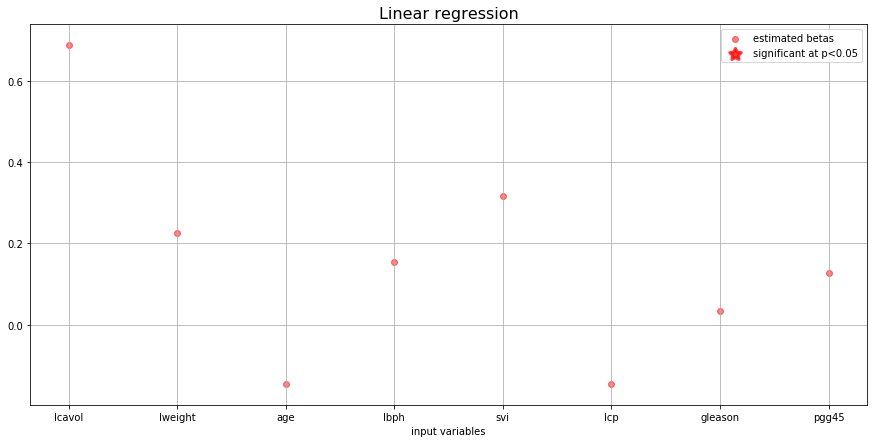

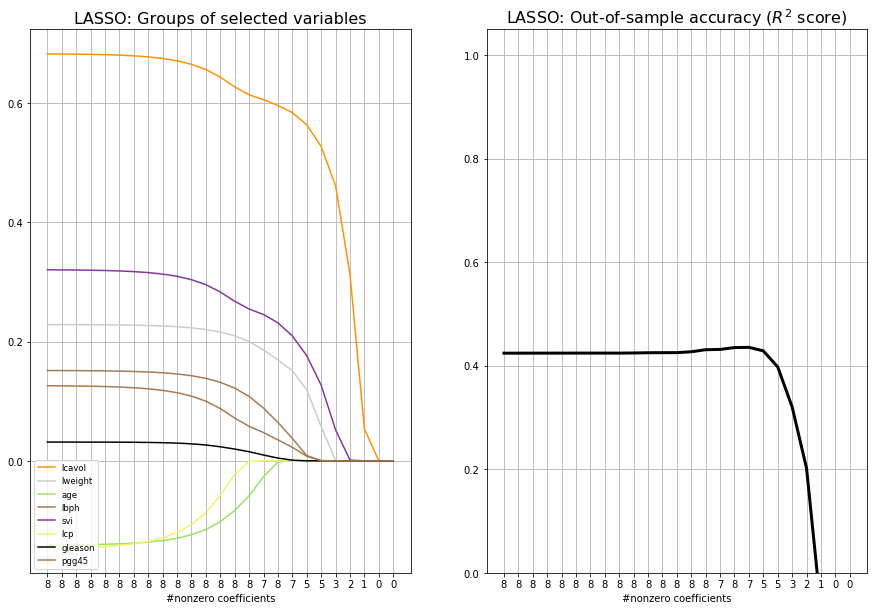

In [71]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)

### no significants (trending significant at 0.08 is also single most predictive variable); 7 items not full set of 9 variables were most predictive -> the widely practiced Gleason score (?) comes up as distrubing prediction

In [69]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.456
Date:                Thu, 08 Mar 2018   Prob (F-statistic):              0.185
Time:                        18:25:46   Log-Likelihood:                -229.14
No. Observations:                  97   AIC:                             474.3
Df Residuals:                      89   BIC:                             494.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         0.6883      0.390      1.764      0.0

# Heart dataset (ISL)

In [ ]:
These data contain a binary outcome HD for 303 patients who presented with chest pain. 

In [222]:
import pandas as pd
df_heart = pd.read_csv('dataset_heart_ISL.csv').fillna(value=0)
feat_names = ['Age', u'Sex', u'RestBP', u'Chol', u'Fbs',
       u'RestECG', u'MaxHR', u'ExAng', u'Oldpeak', u'Slope', u'Ca', u'Thal', u'ChestPain']
y = np.asarray(df_heart['AHD'] == 'Yes', dtype=np.float)

df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_heart[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_heart[feat_names[-2:]])
#pd.concat([df_part1.reset_index() + df_part2.reset_index()], axis=1)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)

alpha: 0.0001 acc: 0.36 active_coefs: 19
alpha: 0.0002 acc: 0.36 active_coefs: 19
alpha: 0.0002 acc: 0.36 active_coefs: 19
alpha: 0.0003 acc: 0.36 active_coefs: 19
alpha: 0.0005 acc: 0.36 active_coefs: 19
alpha: 0.0008 acc: 0.36 active_coefs: 19
alpha: 0.0012 acc: 0.36 active_coefs: 19
alpha: 0.0017 acc: 0.36 active_coefs: 18
alpha: 0.0026 acc: 0.36 active_coefs: 17
alpha: 0.0039 acc: 0.36 active_coefs: 17
alpha: 0.0059 acc: 0.37 active_coefs: 17
alpha: 0.0089 acc: 0.37 active_coefs: 16
alpha: 0.0133 acc: 0.37 active_coefs: 14
alpha: 0.0200 acc: 0.37 active_coefs: 14
alpha: 0.0301 acc: 0.37 active_coefs: 12
alpha: 0.0453 acc: 0.36 active_coefs: 11
alpha: 0.0681 acc: 0.33 active_coefs: 9
alpha: 0.1024 acc: 0.27 active_coefs: 6
alpha: 0.1540 acc: 0.19 active_coefs: 4
alpha: 0.2315 acc: -0.00 active_coefs: 3
alpha: 0.3481 acc: -0.00 active_coefs: 0
alpha: 0.5233 acc: -0.00 active_coefs: 0
alpha: 0.7867 acc: -0.00 active_coefs: 0
alpha: 1.1828 acc: -0.00 active_coefs: 0
alpha: 1.7783 acc: 

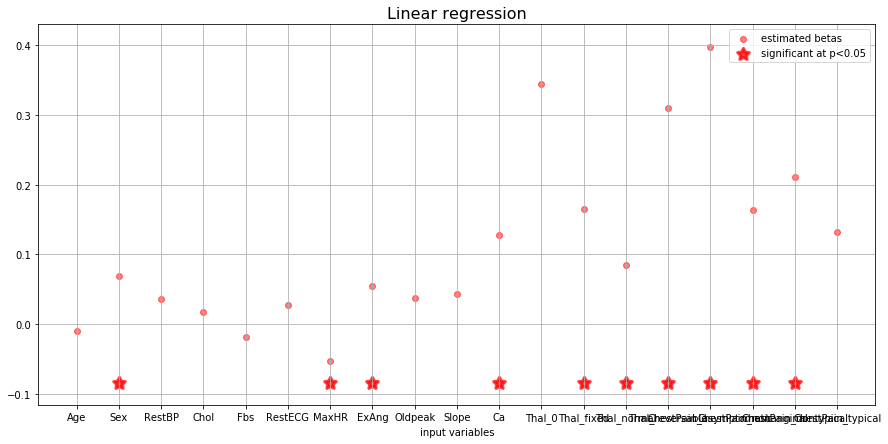

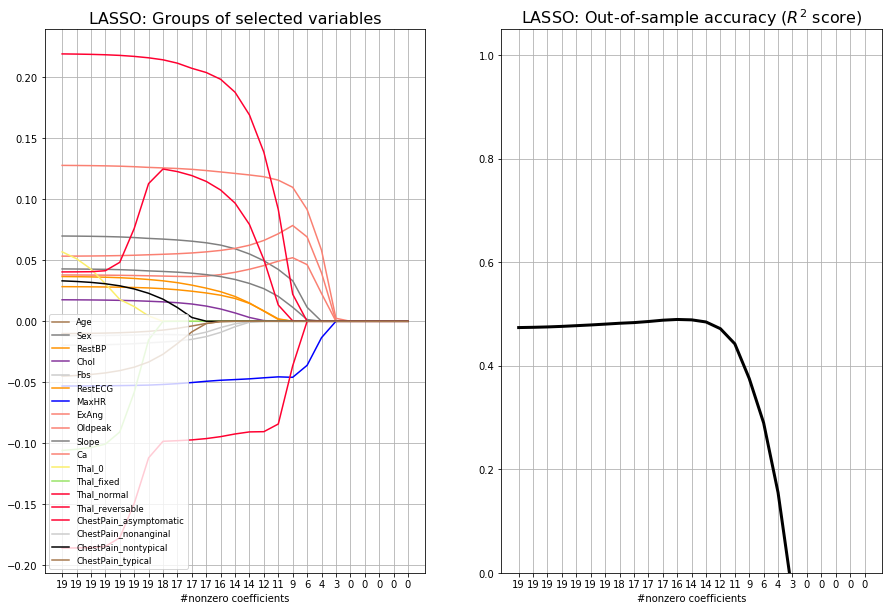

In [223]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)